title: PDE From Data
date: 2019-11-21
description: Modeling a Population PDE
tags: 
  - classes

Given a set of population data, we seek to create and fit a partial differential equation that can be used to predict future growth of the population to estimate the number of K-12 students. To do so, we also seek to fit the death and birth rate of the population.

The data can be seen below our importing libraries.

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import statsmodels.api as sm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import optimize as opt

def pltAttr(x='', y='', title=None, legend='upper right', save=None):
    plt.tight_layout()
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

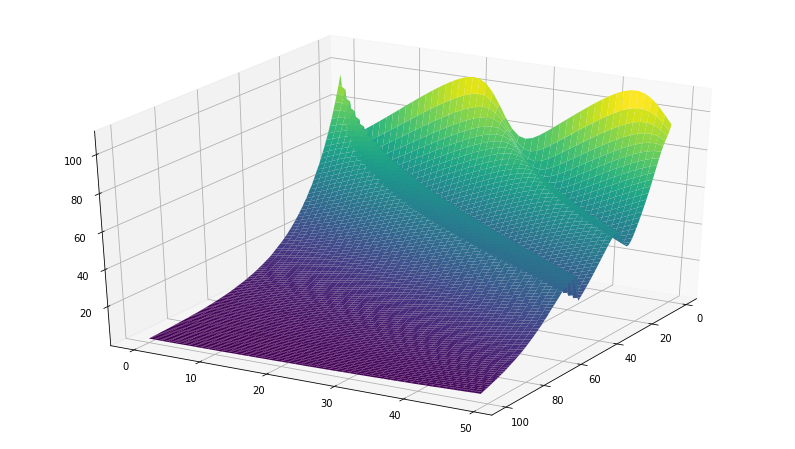

In [5]:
#load data
data = loadmat('population_density_data.mat')
data = data['M_students']

#make appropriate meshgrid
x = np.arange(1, 101)
t = np.arange(0, 50)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, data, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim=30)
plt.show()

The population seems to follow the path of a "traveling wave", only with some needed decay terms. Luckily for us, there's a PDE that describes this. It is something like this (with our tweaks):

\begin{align}
u_x + u_t + &f(x)u = 0 \\
u(x,0) &= g(x) \\
u(0,t) &= h(t)
\end{align}

The tricky part of this modeling was finding $f(x)$ (the death rate) and extending $h(t)$ (essentially all the births). Since we will be applying a finite difference scheme to this, I'm not concerned about "continuizing" these functions. Having them defined on a discrete set will be enough. For starters, we simply define $g(x)$ to be the initial array of data given to us that corresponds to year 0.

To solve for $f(x)$ we manually find the death rate, and for $h(t)$ we perform a linear regression to find all birthrates. Details can be found below.

## Fitting Birth Rate $h(t)$

We noted that $h(t)$ was just all age 0 (newborns) given at all times. This means to extend it into new years we needed to find the birth rate for each age. We assumed this to be necessary only for ages 15-45 (being overly cautious). To find these rates we perform a regression mapping a linear combination of population at certain ages to the number of newborns the following year. This performed with an excellent MSE.

In [3]:
#starting at year one (avoiding weird blip)  and ending before the last year (since we don't have number ot map it to)
#take 15-45 years olds and number of births
X = data[1:-1,15:45]
#make sure to increment y since it affects the next year
y = data[2:,0]

#perform linear regression from age to number of births
results = sm.OLS(y, X).fit_regularized(alpha=10**-20, L1_wt=0)
birth_rate = results.params

#zero any that ended up *slightly* below 0
birth_rate[birth_rate < 0] = 0

#calculate MSE
mse = np.sum( (y - np.sum(X*birth_rate, axis=1))**2 )
print(f"MSE = {mse}")

MSE = 4.6448130099413175e-26


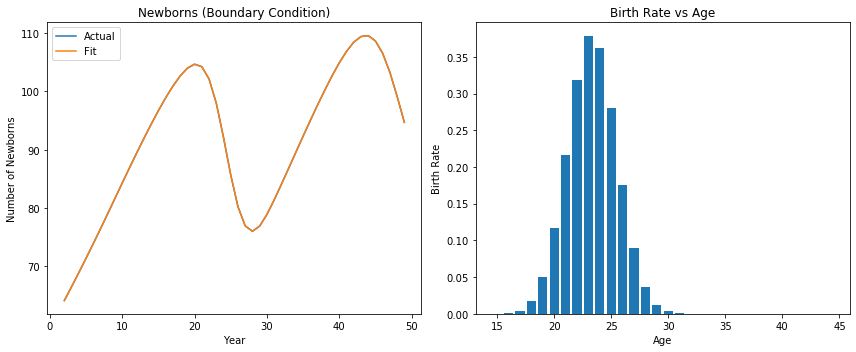

In [4]:
#check out our fit
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.arange(2, 50), y, label="Actual")
plt.plot(np.arange(2, 50), np.sum(X*birth_rate, axis=1), label="Fit")
pltAttr("Year", "Number of Newborns", "Newborns (Boundary Condition)", legend='upper left')
plt.subplot(122)
plt.bar(np.arange(15, 45), birth_rate)
pltAttr('Age', 'Birth Rate', "Birth Rate vs Age", legend=None)
plt.tight_layout()
plt.show()

Thus we define $h(t)$
$$ h(t) = \sum_{x=15}^{45} b_{rate}( x )u(x, t-1) $$
Which is essentially a sum of all the babies that each age group will produce. In the case of continuous data this could be transformed into an integral by interpolating $b_{rate}$.

## Fitting Death Rate $f(x)$

Next, to find $f(x)$ is to simply find the death rate. We noted that $\frac{u(x+1,t+1)}{u(x,t)}$ gives us the percentage of "survivors" who lived to the next year, so that means $f(x) = 1 - \frac{u(x+1,t+1)}{u(x,t)}$ gives us the percentage of people who perished each year. Since we have data, we simply performed this and then averaged it over all the possible years for each age.

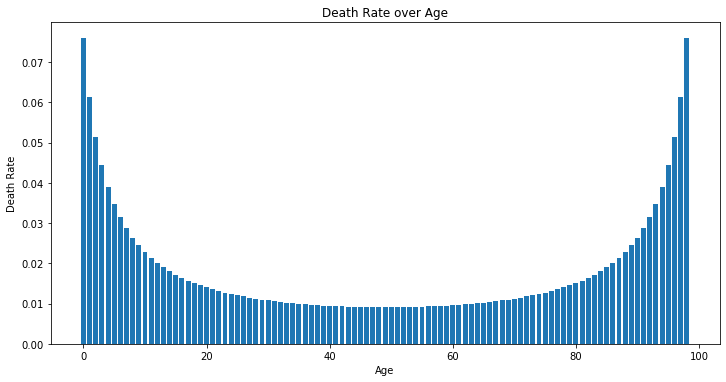

In [5]:
#find death rate
ages = np.arange(0,99)
d_rates = []
for age in ages:
    temp = 1 - data[1:, age+1] / data[:-1, age]
    d_rates.append( temp.mean() )  
d_rates = np.array(d_rates)

#plot it to show us
plt.figure(figsize=(10,5))
plt.bar(ages, d_rates)
pltAttr('Age', 'Death Rate', "Death Rate over Age", legend=None)
plt.show()

Thus we define $f(x)$ as 
$$ f(x) = d_{rate} ( x ) $$
Note as before, if we would like this to be continuous, we could change our $d_{rate}$ by interpolating, but since we'll apply finite difference to it, there's not much value in that for us. (Note this also appears to be the pdf of Beta(1/2, 1/2) which may be how the data was formed). 

## Applying Finite Difference Scheme

Now we use a finite difference scheme to solve for the next 30 years. It goes as follows:

\begin{align}
&u_x + u_t + f(x)u = 0 \\
\implies &\frac{U^{n}_{j} - U^{n}_{j-1}}{h} + \frac{U^{n+1}_{j} - U^{n}_{j}}{k} + f(x)U^{n}_{j} = 0\\
\implies &U^{n+1}_{j} = U^{n}_{j}(1 - f(x)k) - \frac{k}{h}(U^{n}_{j} - U^{n}_{j-1})
\end{align}

Using this we solve for the next 30 years.

In [6]:
#Use Finite Difference to calculate next steps
ans = np.zeros((30, 100))
h = 1
k = 1

#perform it for the initial year, using last year of data
ans[0, 0] = np.sum(data[-1,15:45]*birth_rate)
ans[0,1:] = data[-1,1:] * (1 - d_rates*k) - (k/(2*h)) * ( data[-1,1:] - data[-1,:-1] )

#then interate through performing it
for i in range(1,len(ans)):
    if i!=0:
        ans[i, 0] = np.sum(ans[i-1, 15:45]*birth_rate)
    ans[i,1:] = ans[i-1,1:] * (1 - d_rates*k) - (k/(h)) * ( ans[i-1,1:] - ans[i-1,:-1] )

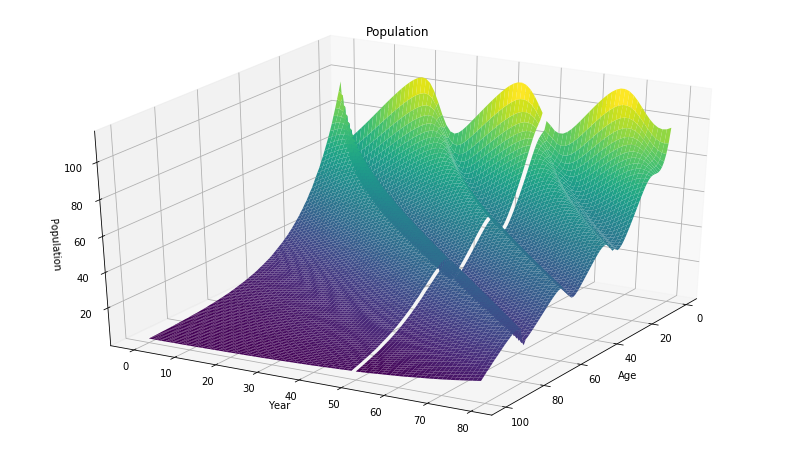

In [7]:
#make appropriate meshgrid and plot OG data
x = np.arange(1, 101)
t = np.arange(0, 50)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, data, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#make appropriate meshgrid and plot our approximation
x = np.arange(1, 101)
t = np.arange(50, 80)
X, T = np.meshgrid(x, t)
ax.plot_surface(X, T, ans, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Population')
ax.view_init(azim=30)
ax.set_xlabel('Age')
ax.set_ylabel('Year')
ax.set_zlabel('Population')
plt.show()

It appears to be a great fit! While this was something of a contrived problem for class, the same general principles could be applied to fitting a real population curve, or any other sort of potential PDE problem.